# Teste Bayesiano A / B com Python
Vamos imaginar que temos uma experiência em execução, onde queremos saber se são as Alpacas (Llamas) ou os Ursos que apresentam melhor performance para a taxa de conversào de usuários na página de destino de nosso site.

## A distribuição BETA

Em teoria da probabilidade e estatística, a distribuição beta é uma família de distribuições de probabilidade contínuas definidas no intervalo [ 0 , 1 ] {\displaystyle [0,1]} [0,1] parametrizado por dois parâmetros positivos, denotados por α {\displaystyle \alpha } \alpha e β {\displaystyle \beta } \beta, que aparecem como expoentes da variável aleatória e controlam o formato da distribuição.

A distribuição beta tem sido aplicada para modelar o comportamento de variáveis aleatórias limitadas a intervalos de tamanho finito em uma grande quantidade de disciplinas.

### Utilizando a distribuição Beta em nosso experimento

A idéia geral por trás do teste de taxa de conversão bayesiana é gerar duas distribuições que verifiquem todas as taxas possíveis e atualizá-las com informações sobre o desempenho do teste, ajustando a nossa expectativa da taxa mais representativa de acordo com os resultados.

Podemos representar isso com a distribuição Beta que possui dois parâmetros: α, que representa as conversões bem-sucedidas e β, que representa as pessoas que saíram sem converter.

Podemos pensar em α e β como probabilidades: 10 pra 1, 2 pra 3, e assim por diante. A única diferença é que 4 pra 6 representa um resultado mais representativo que, na mesma taxa de conversão, 2 pra 3.

Antes de iniciarmos o experimento, não temos idéia se, entre Llamas ou Ursos, qual das opções é melhor para conversão.

Digamos que, se não temos ideia alguma sobre qual das opções é melhor, para ambas qualquer taxa de conversão seria igualmente provável. Podemos representar isso com uma única conversão e uma única saída ou Beta (α = 1, β = 1).

Graficamente a distribuição que se parece com o gráfico abaixo, que nos permite entender melhor o código e como plotar uma distribuição Beta.

In [1]:
# importando as bilbiotecas

from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

[Text(0, 0.5, 'density'), Text(0.5, 0, 'conversion rate')]

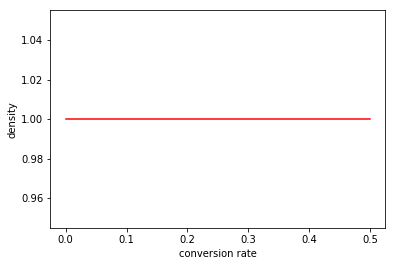

In [2]:
# Para o gráfico
fig, ax = plt.subplots(1, 1) 

# Gerando a distribuição
beta_distribution = beta(1,1)

# Plotando a destribuição

x = np.linspace(0., 0.5, 1000)

ax.plot(x, beta_distribution.pdf(x),color='red')
ax.set(xlabel='conversion rate', ylabel='density')

## Exemplo de plotagem da distribuição BETA

Na realidade, sabemos um pouco sobre as taxas de conversão prováveis. Podemos usar essa informação para descartar resultados improváveis e acelerar nosso teste!

Digamos que experimentamos Alpacas antes e descobrimos que eles convertem cerca de 16% do tempo. Para representar isso, podemos usar a distribuição Beta (16, 100-16). No entanto, podemos ser um pouco céticos sobre o desempenho, então vamos reduzi-la para Beta (8, 50-8).

Ambas as distribuições são mostradas abaixo. Vale a pena brincar com os parâmetros destas funções Beta para entender melhor o nosso estudo.

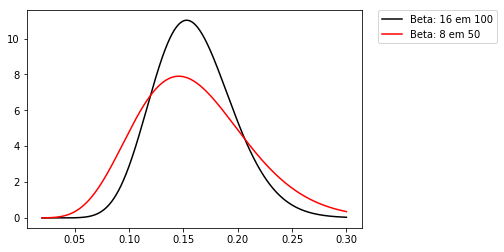

In [3]:
# Para o gráfico
fig, ax = plt.subplots(1, 1) 

x = np.linspace(0.02, 0.3, 1000) 

# Gerando e plotando as distribuições
alpacas1_distribution = beta(16, 100-16)  # conversão de 16 em 100 cliques
alpacas2_distribution = beta(8, 50-8)     # conversão de 8 em 50 cliques

ax.plot(x, alpacas1_distribution.pdf(x),label='Beta: 16 em 100',color='black')
ax.plot(x, alpacas2_distribution.pdf(x),label='Beta: 8 em 50',color='red')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

## Conduzindo o teste A/B

Agora vamos adicionar dados "reais" à essa experiência, porém vamos vamos ter que assumir uma premissa que ainda é desconhecida, os Ursos têm melhor performance do que as Alpacas.

Vamos simular esta modelagem gerando um pequeno número de resultados aleatórios entre 0 e 1, depois escolhendo valores abaixo de um certo ponto de corte.

O corte representa nossa taxa de conversão real e os valores abaixo dela são nossas conversões.

In [4]:
# total de observações (número de pessoas do univeerso amostral)
people_in_branch = 50

# Dados de controle são Alpaca, e dados de experimento são Ursos
np.random.seed(42)
control, experiment = np.random.rand(2, people_in_branch)

# Número de sucassos das Alpacas (controle) de 16%
c_successes = sum(control < 0.16)

# Vamos assumir uma premissa que os Ursos tem uma performance 10% melhor que as Alpacas
delta=1.1
e_successes = sum(experiment < 0.16*delta)

c_failures = people_in_branch - c_successes
e_failures = people_in_branch - e_successes

# Nossos pontos de partida para resultados do experimento
prior_successes = 8
prior_failures = 42

## Verificando o comportamento dos dados iniciais

Vamos dar uma olhada nos resultados da nossa experiência. A primeira coisa que fazemos é pegar nossa pequena quantidade de dados iniciais e adicionar nossos pontos de partida aos dois grupos do teste (Alpacas=controle e Ursos=experimento). Depois disso, geramos as distribuições posteriores e fazemos alguns gráficos dos resultados.

[Text(0, 0.5, 'density'), Text(0.5, 0, 'conversion rate')]

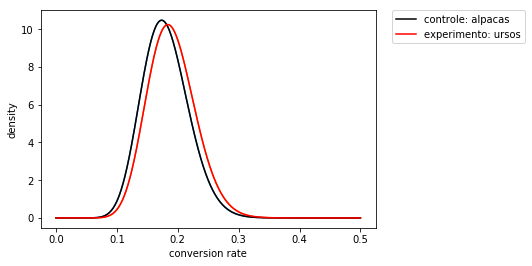

In [5]:
# Para o gráfico
fig, ax = plt.subplots(1, 1) 

# Controle
c_alpha, c_beta = c_successes + prior_successes, c_failures + prior_failures
# Experimento
e_alpha, e_beta = e_successes + prior_successes, e_failures + prior_failures

x = np.linspace(0., 0.5, 1000) 

# Gerando e plotando as distribuições
c_distribution = beta(c_alpha, c_beta)  # controle representa as Alpacas
e_distribution = beta(e_alpha, e_beta)  # experimento representa os Ursos

ax.plot(x, c_distribution.pdf(x))
ax.plot(x, e_distribution.pdf(x))

ax.plot(x, c_distribution.pdf(x),label='controle: alpacas',color='black')
ax.plot(x, e_distribution.pdf(x),label='experimento: ursos',color='red')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set(xlabel='conversion rate', ylabel='density')

## Aumentando o tamanho do espaço amostral

O resultado do gráfico acima demonstra uma diferença entre os dois grupos, mas eles se sobrepõem, tanto que é difícil dizer se esta diferença é estatísticamente significativa.
Precisamos de mais dados para poder tirar uma melhor conclusão, portanto vamos aumentar o tamanho do espaço amostral para 4000 pessoas.

In [14]:
more_people_in_branch = 4000

# Controle são as Alpacas, experimento são os Ursos
control, experiment = np.random.rand(2, more_people_in_branch)

# Adicinando aos dados existentes
# Performance das Alpacas (controle) de 16% ee a performance dos Ursos (experimento) é 10% superior

c_successes += sum(control < 0.16)
e_successes += sum(experiment < 0.16*delta)

c_failures += more_people_in_branch - sum(control < 0.16)
e_failures += more_people_in_branch - sum(experiment < 0.16*delta)

## Verificando o comportamento dos dados

Vamos plotar as curvas de distribuição Beta para o controle (Alpacas) e o experimento (Ursos), e observar se existe uma diferença significativa entre oss dados.

[Text(0, 0.5, 'density'), Text(0.5, 0, 'conversion rate')]

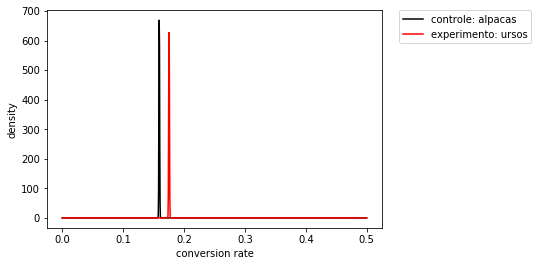

In [15]:
# Para o gráfico
fig, ax = plt.subplots(1, 1) 

# Controle
c_alpha, c_beta = c_successes + prior_successes, c_failures + prior_failures

# Experimento
e_alpha, e_beta = e_successes + prior_successes, e_failures + prior_failures


# Gerando e plotando as distribuições

x = np.linspace(0., 0.5, 1000)

c_distribution = beta(c_alpha, c_beta)
e_distribution = beta(e_alpha, e_beta)

ax.plot(x, c_distribution.pdf(x),label='controle: alpacas',color='Black')
ax.plot(x, e_distribution.pdf(x),label='experimento: ursos',color='red')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set(xlabel='conversion rate', ylabel='density')

## Confirmação da hipótese

Agora podemos dizer que a performance dos Ursos (experimento) está claramente melhor do que a performance das Alpacas (controle), pois as curvas apresentam uma área comum bastante reduzida devido ao aumento no tamanho das amostras e a diminuição da variância dos dados.
Vamos calcular o p-valor para verificar o limite da diferença entre os dois grupos

In [8]:
# Arguments are x values so use ppf - the inverse of cdf
print(c_distribution.ppf([0.025, 0.5, 0.975]))
print(e_distribution.ppf([0.025, 0.5, 0.975]))

# [ 0.14443947  0.15530981  0.16661068]
# [ 0.15770843  0.16897057  0.18064618]

[0.15320328 0.16433567 0.17588731]
[0.17005399 0.18165556 0.19365476]


In [9]:
sample_size = 10000

c_samples = pd.Series([c_distribution.rvs() for _ in range(sample_size)])
e_samples = pd.Series([e_distribution.rvs() for _ in range(sample_size)])

p_value = 1.0 - sum(e_samples > c_samples)/sample_size
p_value

0.020299999999999985

In [10]:
p_value < 0.05

True

Como o p-valor é menos que o limite de 0.05, podemos rejeitar a hipótese de que os dois grupos performam igual, e dizer que temos 95% de confiança que os Ursos (experimento) performam melhor que as Alpacas (controle).

## Curva da porcentagem acumulada dos dados do experimento divididos pelos dados de controle

Esta curva revela o quanto a performance dos Ursos (experimento) é melhor em relação à performance das Alpacas (controle).

[Text(0, 0.5, 'CDF'), Text(0.5, 0, 'Bears / Alpacas')]

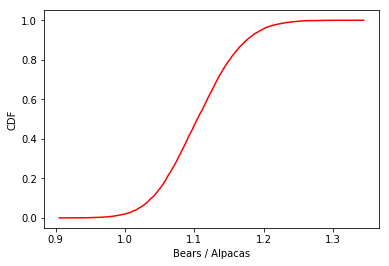

In [11]:
fig, ax = plt.subplots(1, 1)

ser = pd.Series(e_samples/c_samples)

# Make the CDF
ser = ser.sort_values()
ser[len(ser)] = ser.iloc[-1] 
cum_dist = np.linspace(0., 1., len(ser))
ser_cdf = pd.Series(cum_dist, index=ser)

ax.plot(ser_cdf, color='red')
ax.set(xlabel='Bears / Alpacas', ylabel='CDF')